# Spotify Recommendation Engine

This is a recommendation engine for Spotify. You first log in with your Spotify account and select a playlist you want it to analyze. Then, it downloads a dataset containing around 80,000 songs (after data processing). The dataset has specific metrics on each song, including danceability, tempo, loudness, etc. It then creates a subset of the dataset which contains only the songs in your playlist. After, it goes through every song, and calculates the cosine similarity between your songs and every other song in the dataset. It finds the top 50 most similar songs, and creates a Spotify playlist on your account containg those

In [2]:
# Spotipy is the library we use to interact with the Spotify API
# Lingua language detector is used to detect the language of track titles
!pip3 install spotipy lingua-language-detector

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.2/354.2 kB 22.4 MB/s eta 0:00:00


# Language Detection

One issue with the dataset is that there is no information on the language of the song. This function attempts to mitigate that problem by using the lingua language recognition library to try to recognize the language of the text passed in. It is then used in the cell below to predict the language of the song based on the language of the title

In [3]:
from lingua import Language, LanguageDetectorBuilder

# TODO: Expand this to more than four languages
languages = [Language.ENGLISH, Language.FRENCH, Language.GERMAN, Language.SPANISH]

# Forms the language detector based on the list above
detector = LanguageDetectorBuilder.from_languages(*languages).build()

def detect_lang(text):
  """

  This function predicts the language of the text passed into it using the lingua package

  """

  if not isinstance(text, str) or not text.strip():
      return "unknown"
  try:
      return detector.detect_language_of(text)
  except:
      return "unknown"


# Dataset

Dataset taken from [maharshipandya/spotify-tracks-dataset](https://huggingface.co/datasets/maharshipandya/spotify-tracks-dataset) on Hugging Face

In [4]:
import pandas as pd

# Dataset containg 114,000 songs and metrics about all of them (detailed at the top)
df = pd.read_csv("hf://datasets/maharshipandya/spotify-tracks-dataset/dataset.csv").iloc[:,1:]

# Removes tracks with duplicate track ids
df = df.drop_duplicates(subset=["track_id"])

# Keep only the most popular versions of duplicate songs
# Yes we already removed duplicates, however different versions
# of songs with the same title will have different track ids
df = df.sort_values("popularity", ascending=False)
df = df.drop_duplicates(subset=["track_name"])

# Appends a "title_lang" column to the dataset with the predicted language of the song
# based on the "track_name"
df["title_lang"] = df["track_name"].apply(detect_lang)

df

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,title_lang
20001,3nqQXoyQOWXiESFLlDF1hG,Sam Smith;Kim Petras,Unholy (feat. Kim Petras),Unholy (feat. Kim Petras),100,156943,False,0.714,0.472,2,...,1,0.0864,0.01300,0.000005,0.2660,0.238,131.121,4,dance,Language.ENGLISH
51664,2tTmW7RDtMQtBk7m2rYeSw,Bizarrap;Quevedo,"Quevedo: Bzrp Music Sessions, Vol. 52","Quevedo: Bzrp Music Sessions, Vol. 52",99,198937,False,0.621,0.782,2,...,1,0.0440,0.01250,0.033000,0.2300,0.550,128.033,4,hip-hop,Language.ENGLISH
20008,4uUG5RXrOk84mYEfFvj3cK,David Guetta;Bebe Rexha,I'm Good (Blue),I'm Good (Blue),98,175238,True,0.561,0.965,7,...,0,0.0343,0.00383,0.000007,0.3710,0.304,128.040,4,dance,Language.ENGLISH
67356,5ww2BF9slyYgNOk37BlC4u,Manuel Turizo,La Bachata,La Bachata,98,162637,False,0.835,0.679,7,...,0,0.0364,0.58300,0.000002,0.2180,0.850,124.980,4,latin,Language.FRENCH
67358,6Sq7ltF9Qa7SNFBsV5Cogx,Bad Bunny;Chencho Corleone,Un Verano Sin Ti,Me Porto Bonito,97,178567,True,0.911,0.712,1,...,0,0.0817,0.09010,0.000027,0.0933,0.425,92.005,4,latin,Language.SPANISH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14040,4XNJbPCchL1rTnX0qEPy25,Kidz Bop Kids,Diversión para los peques,Party Rock Anthem,0,204933,False,0.686,0.742,9,...,0,0.0768,0.00154,0.000000,0.2070,0.447,129.988,4,children,Language.ENGLISH
33245,20zzr5ptoz7htV9Li3WEqo,The Maine,Emo Christmas 2022,Santa Stole My Girlfriend,0,182960,False,0.677,0.493,7,...,1,0.0323,0.60100,0.000000,0.3060,0.738,107.993,4,emo,Language.ENGLISH
33285,5mx3rrfxoDZqX5kR2XJK6q,Hobo Johnson,New Hip Hop Icons,Peach Scone,0,212799,True,0.583,0.408,7,...,1,0.5640,0.64800,0.000000,0.3090,0.612,74.738,3,emo,Language.ENGLISH
33397,4lOw9U5IDaRHOYM9p1TGxv,Real Friends,Emo Christmas 2022,I Had A Heart,0,157746,False,0.608,0.851,1,...,1,0.0282,0.01910,0.000000,0.1200,0.409,129.997,4,emo,Language.ENGLISH


In [5]:
from sklearn.preprocessing import StandardScaler

# The columns of the data set that we want to focus on
feature_cols = [
    "danceability", "energy", "loudness", "speechiness",
    "acousticness", "instrumentalness",  "liveness", "valence",
    "tempo"
]

# Extract only those columns from the dataset
df_with_only_feature_cols = df[feature_cols].copy()

# Scale all of the parameters to a value between -1 and 1
scaler = StandardScaler()
df_feature_cols_scaled = scaler.fit_transform(df_with_only_feature_cols)

# Spotify Auth

Follow these steps to authenticate with Spotify

1) Run the cell. The program will output a URL for you to visit. Click it
2) Log into Spotify and, when prompted, authorize the application to access your Spotify account
3) After you click authorize, it will say "Cannot load page." **This is normal.** Copy the URL, which should start with "http://127.0.0.1:8080" and paste it into the given text field in the program output
4) If successful, it will return with no output or errors

In [15]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth

# Prompts the user to log in with their Spotify account
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id="16db899e7b314610b4bbdfb79787cdd7",
                                                           client_secret="39eb5b78be4b44609ddfda4216270988",
                                                           redirect_uri="http://127.0.0.1:8080",
                                                           scope="user-library-read user-top-read user-follow-read playlist-read-private playlist-read-collaborative playlist-modify-public playlist-modify-private",
                                                           open_browser=False))

# Retrieves all of the users current playlists
playlists = sp.current_user_playlists()


Go to the following URL: https://accounts.spotify.com/authorize?client_id=16db899e7b314610b4bbdfb79787cdd7&response_type=code&redirect_uri=http%3A%2F%2F127.0.0.1%3A8080&scope=user-library-read+user-top-read+user-follow-read+playlist-read-private+playlist-read-collaborative+playlist-modify-public+playlist-modify-private
Enter the URL you were redirected to: http://127.0.0.1:8080/?code=AQA7vGXBgBIKX4cCdG15y5L45sdx5iv18s4WXsD9GSOl5E0xdwIC6h_pXK6mmxK-Hpgx4T5-jwreF_Bs507_pMSOSzoAH9wZ4Q6QHyQDxxXIryBq_853Pu_EquMeJnHloASH4DGeNkHJnVQnmPb7JdV4VrhrdUblabwN1hXfRBK_LXmOj0pFPdWK37wQB8j1y9SoKfWLCEGWwENnpzM3seKiQ3DiR2yV2hXfxMo0SJJSn0DsYsNopA6MRVRq4ckqlQAY3F6cLo_HWRpgm5zav0L7LVQQzENFuIqfm3DlRm93jLQCoqoaVV3xjxRweaCsFnc8CVUPCUPEoViycp4GfZ1IsW4xTQ37v1AC-WfF_eswrw


In [16]:
import numpy as np

def get_playlist_track_ids(playlist_id):
  """

  This function retrives all of the Spotify track id's for every song in the provided playlist

  """

  # Retrive the playlist details from the Spotify API
  playlist_result = sp.playlist_items(playlist_id=playlist_id)

  # Retrive the tracks from the playlist
  tracks = playlist_result["items"]

  # Iterate through the results to retrieve all the tracks
  # as the Spotify API only returns 100 tracks at once
  while playlist_result["next"]:
    playlist_result = sp.next(playlist_result)
    tracks.extend(playlist_result["items"])

  # For every single track in the playist, get the track_id, and store it in the array
  playlist_track_ids = [track["track"]["id"] for track in tracks]

  print(f"Playlist has {len(playlist_track_ids)} songs in it")

  return playlist_track_ids

# get_playlist_track_ids("Vibes")

# KMeans clustering & Cosine Similarity

This is the algorithm that drives the recommendation engine. It works through first using KMeans clustering, and then cosine similarity.

# KMeans Clustering Algorithm

<table><tr>
  <td>
  <img src="https://drive.google.com/uc?export=view&id=1orXhJOuCq2bsKpbJ-Yd4zEMBCiRFEK_e" alt="drawing" width="500" height="250"/>
  <p>1) Random centroids based on data</p>
  </td>

  <td>
  <img src="https://drive.google.com/uc?export=view&id=1VHTFaTgWnHR-FaMQOhth8bWTt8AX5BLg" alt="drawing" width="500" height="250"/>
  <p>2) Assign each point to the nearest centroid</p>
  </td>

  <td>
  <img src="https://drive.google.com/uc?export=view&id=1IuOl8GnAEfrXNs0Ke_3e6hyYLiUeEoNg" alt="drawing" width="300" height="250"/>
  <p>3) Recalculate centroids to be the <br/>mean of each point in it's respective cluster</p>
  </td>

  <td>
  <img src="https://drive.google.com/uc?export=view&id=1iaUPSmM0p9i1rt2anz_pWsY-kl8r70WS" alt="drawing" width="500" height="250"/>
  <p>4) Repeat step 3 until centroids stabilize</p>
  </td>

</tr></table>

<i>Images taken from GeeksforGeeks</i>

# Cosine Similarity

Cosine similarity measures the similarity between two vectors by taking the cosine of the angle between them. See below:

<img src="https://drive.google.com/uc?export=view&id=1-jIdeqNc00XRUkvfPlET6cjDYFYmnzhJ" width="500" height="500" />

In [47]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from collections import Counter

def calculate_cosine_similarity(playlist_track_ids):
  """

  This function calculates the cosine similarity between the user's taste preferences
  and every song in the dataset

  """

  print("Performing KMeans clustering and cosine similarity")

  # Returns an array based on whether the track is in the user's playlist
  # E.x. [False, False, True, False, True, True, ...]
  mask = df["track_id"].isin(playlist_track_ids)

  # Returns the featued_cols_scaled dataframe with only the tracks in the user's playlist
  user_feature_rows = df_feature_cols_scaled[mask]

  print(f"Of the songs in your playlist, {len(user_feature_rows)} are present in the dataset")
  print("Only this subset will be used for the analysis")

  if len(user_feature_rows) == 0:
    print("None of the songs in your playlist are present in the dataset, so unfortunately this program will not work\nTry selecting a different playlist")
    return []

  # N of clusters for KMeans
  k = 12

  if len(user_feature_rows) < k:
    print(f"Less than {k} of your songs are present in the dataset, so a less optimal recommendation algorithm will have to be used")

    # If the dataset does not contain at least k number of tracks in the playlist
    # then Kmean clustering will not work, and we have to resort to the less-optimial version

    user_vector = np.mean(user_feature_rows, axis=0)

    # Calculates the cosine similarity between the user's vector
    # and every song in the dataset
    scores = cosine_similarity([user_vector], df_feature_cols_scaled)[0]

    return scores

  # Train k-means on the playlist tracks with the number of clusters specified above
  kmeans = KMeans(n_clusters=k)
  labels = kmeans.fit_predict(user_feature_rows)

  # Determine the largest cluster
  largest_cluster = np.bincount(labels).argmax()

  # Select only tracks within that largest cluster
  main_group = user_feature_rows[labels == largest_cluster]

  # Average each track's features of the largest cluster to get the user's vector
  # Example
  """

  main_group = [
                [0.08065439  1.02577417  0.18059055 -0.30362581 -0.92062283 -0.54889961 -0.64527423  1.54842045 -1.24960669],
                [1.02281259  0.23211403  0.29507301 -0.52535147 -0.7779345  -0.55261452 -0.44562649  1.16194747 -0.19854738],
                ...
               ]

  user_vector = [7.53624530e-01, 5.04513675e-01, ...]

  """
  user_vector = main_group.mean(axis=0)

  # Compute similarity with the user's vector against all tracks
  scores = cosine_similarity([user_vector], df_feature_cols_scaled)[0]

  return scores

# calculate_cosine_similarity(get_playlist_track_ids("6qjPpKtBqUP5FBnKNo0IRd"))

# Determing Optimal Number of Clusters

To determine how many clusters we should use in the KMeans algorithm we use the "Elbow Method." You start by interating over a range of values that you want to try for the number of clusters. In the second graph below, we iterate from 1 to 9 clusters. For each k value, you cluster the data with k clusters, and then get the inertia from the algorithm. Inertia is calculated by first calculating the distance between each point in the cluster and the centroid. You then square this sum, repeat it for every cluster, and sum all of the sums up. This is also known as the Within-Cluster Sum of Squares (WCSS). You plot these values on a graph with k on the x axis and the WCSS on the y axis. Then, you find the point where it "bends" and starts to platou (hence the name "Elbow Methods"), and that k value is the optimal number of clusters. Here is a graph to more easily see the phenomenon, and the calculations visulized

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*zlZOSJB_DISgUxb06QwISw.png" width="800" />

<img src="https://media.geeksforgeeks.org/wp-content/uploads/20241028173908396970/Elbow-Method.png" width="800" />

In [ ]:
# Running KMeans clustering for k values from 1 to 50 is intensive and takes a long time
# so it is disabled by default. Set this to True if you would like to see the elbow graph
# generated based on the dataset
GENERATE_ELBOW_GRAPH = False

Text(0.5, 0, '# of Clusters')

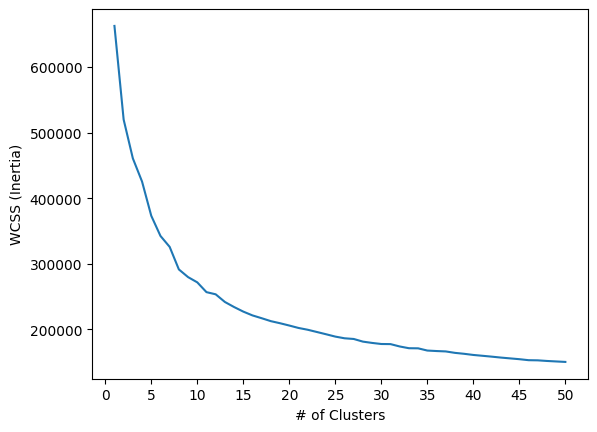

In [ ]:
import matplotlib.ticker as ticker

if GENERATE_ELBOW_GRAPH:

  inertia = []

  # For k = 1 to k = 50 cluster the data with k clusters and get the inertia of each iteration
  for i in range(1,51):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df_feature_cols_scaled)
    inertia.append(kmeans.inertia_)

  fig, ax = plt.subplots()

  ax.plot(range(1,51), inertia)

  plt.xticks(np.linspace(1, 50, 50)) # 1-50 incremented by 1
  ax.xaxis.set_major_locator(ticker.MultipleLocator(base=5)) # Only show multiples of 5 on the x axis

  plt.ylabel("WCSS (Inertia)")
  plt.xlabel("# of Clusters")

In [45]:
def get_most_common_playlist_language(playlist_track_ids):
  """

  This functions finds the most common language of songs in the provided playlist

  """

  # Returns an array based on whether the track is in the user's playlist
  # E.x. [False, False, True, False, True, True, ...]
  mask = df["track_id"].isin(playlist_track_ids)

  # Filter the dataset to only include songs in the users playlist using the mask defined above
  df_with_only_user_songs = df[mask]

  # Get a list of all the languages present in the users playlist
  song_languages = list(df_with_only_user_songs["title_lang"])


  # Find the most common language present in the playlist
  """

  Counter(song_languages) = Counter({Language.ENGLISH: 71, Language.FRENCH: 2, Language.SPANISH: 2, Language.GERMAN: 1})

  Counter(song_languages).most_common(1) = [(Language.ENGLISH, 71)]

  Counter(song_languages).most_common(1)[0] = (Language.ENGLISH, 71)

  Counter(song_languages).most_common(1)[0][0] = Language.ENGLISH

  """
  most_common_playlist_language = Counter(song_languages).most_common(1)[0][0]

  # The last parts converts the language to standard English
  # Language.ENGLISH -> English
  print(f"Analyzed the most common song language in the playlist to be {str(most_common_playlist_language).split(".")[1].capitalize()}")

  return most_common_playlist_language

# get_playlist_language(get_playlist_track_ids("6qjPpKtBqUP5FBnKNo0IRd"))

In [34]:
import datetime
from IPython.display import display, HTML

def analyze_playlist(playlist_id):
  """

  This function analyzes the similarity between the user's playlist
  and every song in the dataframe. It then creates a playlist on the user's
  Spotify account containing the top 50 most similar songs

  """

  # Get all the track ids of every song in the users playlist
  playlist_track_ids = get_playlist_track_ids(playlist_id)

  # Calculate the cosine similarity between each of the tracks in the user's playlist
  # and every other song in the dataset
  cosine_similarity_scores = calculate_cosine_similarity(playlist_track_ids)

  if len(cosine_similarity_scores) == 0:
    return

  # Append a column to each song containing it's cosine similarity with the user
  df["similarity"] = cosine_similarity_scores

  # Assemble the most similar songs for the user
  recommendations = (
      df[~df["track_id"].isin(playlist_track_ids)] # Retrives all tracks in the dataset that are not in the user's playlist (~ means not)
      .sort_values("similarity", ascending=False) # Sort the dataframe by the cosine similarity, from greatest to least
  )

  # Filter the playlist to only have songs in the playlist's most common language
  recommendations = recommendations[recommendations["title_lang"] == get_most_common_playlist_language(playlist_track_ids)]

  # Get the top 5 genres in the playlist
  playlist_genres = df[df["track_id"].isin(playlist_track_ids)]["track_genre"]
  top_genres = playlist_genres.value_counts().head(5).index.tolist()

  print(f"Top 5 generes in the playlist are {", ".join(top_genres[:-1])}, and {top_genres[-1]}\nThe recommendations will be limited to these genres")

  # Filter the recommendations to only include the top 5 genres in the playlist
  recommendations = recommendations[recommendations["track_genre"].isin(top_genres)]

  # Get the top 50 recommendations
  recommendations = recommendations.head(50)

  # Create a list of all the track ids for the recommendations
  recommendation_ids = list(recommendations["track_id"])

  # Maps playlist ids to the playlist name
  playlist_ids_with_names = {item["id"]: item["name"] for item in playlists["items"]}

  playlist_name = playlist_ids_with_names[playlist_id]

  # Create an empty playlist on the user's Spotify account
  created_playlist = sp.user_playlist_create(
      user=sp.me()["id"], # Current logged in user's id
      name="Spotify Recommendation Engine",
      public=False,
      collaborative=False,
      description=f"Created by Spotify Recommendation Engine on {datetime.date.today().strftime("%m/%d/%Y")} for the playlist {playlist_name} - Hope you enjoy :D"
  )

  # Add all the recommended songs to the newly created playlist
  sp.playlist_add_items(created_playlist['id'], recommendation_ids)

  print("Playlist created in your Spotify account! Hope you enjoy :D")


In [ ]:
import ipywidgets as widgets
from IPython.display import display
import numpy as np

print("Summary of data:")
print(f"Total rows: {len(df)}")
print(f"Total columns: {len(df.columns)}")
print(f"Total genres: {df["track_genre"].nunique()}")

# Maps all of the playlist names to their playlist id
playlist_names_with_ids = {item["name"]: item["id"] for item in playlists["items"]}

playlist_names = ["Choose a playlist"]
# Appends the name of all of the user's playlists to the array
playlist_names.extend([item["name"] for item in playlists["items"]])

box = widgets.VBox(
    [
        widgets.HTML(value="<h3>Choose a playlist to analyze your music taste from</h3>"),
        widgets.Dropdown(options=playlist_names)
    ]
)
output = widgets.Output()

def on_change(change):
  # Set the current playlist to analyze to the one the user selected
  playlist_to_analyze = change["new"]

  # Disable the dropdown
  box.children[1].disabled = True

  print(f"You have chosen {playlist_to_analyze}, analyzing now...")

  playlist_id = playlist_names_with_ids[playlist_to_analyze]

  # Analyze the playlist
  analyze_playlist(playlist_id)

# This will call the on_change function whenever the dropdown is changed
# children[1] corresponds to the dropdown containing the playlist names
box.children[1].observe(on_change, names='value')
display(box)

# Future Improvements

Here are some ideas I came up with that I could implement in the future

1) Add a frontend and make it a website
2) Give user more control over how the algorithm works (e.g. language filtering, genre filtering, num of recommendations, etc)
3) Research performance of KMeans clustering more and look into more efficient/better performing models. To determine whether KMeans was good for this project, I used the Elbow Graph method to determine the optimal number of clusters, and then essentially went based on vibes on whether the generated playlist was good or not